# Guía 1 - Grupo 2
### Matías Bergerman, Pablo Gonzalez Leiro, Tobias Demeco, Matias Tripoli

## Pregunta 1

## Pregunta 2

![Imagen](https://scientificimaging.com/wp-content/uploads/2021/01/lens-WD-focal-length-AFOV-and-FOV-1-1024x576.png)

* Por simetría de triángulos, un triángulo isósceles de $10\ mm$ de base y $35\ mm$ de altura es semejante a uno de $1000\ mm$ de altura y $285.714\ mm$ de base.
* Dividiendo esta longitud por la cantidad de pixeles por linea (1000px) nos da una longitud por pixel del objeto igual a $0.285714\ mm$

## Pregunta 3

## Pregunta 4

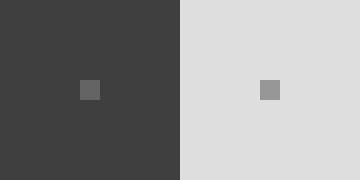

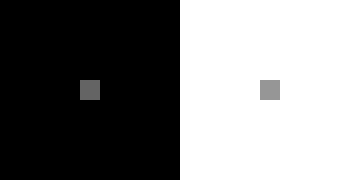

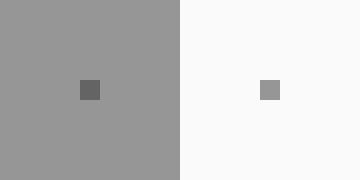

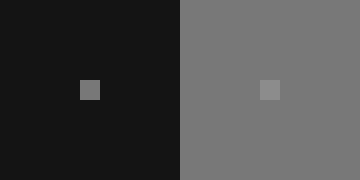

In [59]:
from PIL import Image
import numpy as np

def make_squares(color_out_1, color_out_2, color_in_1, color_in_2, size=(9, 9)):
    c0, c1 = size[0]//2, size[1]//2
    a = np.full(size, color_out_1)
    a[c0, c1] = color_in_1
    b = np.full(size, color_out_2)
    b[c0, c1] = color_in_2
    joined_image = np.concatenate((a, b), axis=1)
    im = Image.fromarray(joined_image.astype(np.uint8), mode="L")
    return im

scale = 20

im = make_squares(63, 223, 100, 150)
display(im.resize(np.array(im.size)*scale, Image.Resampling.NEAREST))

im = make_squares(0, 255, 100, 150)
display(im.resize(np.array(im.size)*scale, Image.Resampling.NEAREST))

im = make_squares(150, 250, 100, 150)
display(im.resize(np.array(im.size)*scale, Image.Resampling.NEAREST))

im = make_squares(20, 120, 120, 140)
display(im.resize(np.array(im.size)*scale, Image.Resampling.NEAREST))

## Pregunta 5

In [1]:
from PIL import Image
import numpy as np

with Image.open("mono.bmp") as im:
    arr = np.asarray(im)
    M = 4
    blocks = [arr[x:x+M, y:y+M] for x in range(0,arr.shape[0],M) for y in range(0,arr.shape[1],M)]

In [3]:
blocks00 = [block[0,0] for block in blocks]
arr00 = np.asarray(blocks00).reshape(64,64)
im00 = Image.fromarray(arr00, mode="L").resize((256,256), Image.Resampling.NEAREST)

blocks11 = [block[1,1] for block in blocks]
arr11 = np.asarray(blocks11).reshape(64,64)
im11 = Image.fromarray(arr11, mode="L").resize((256,256), Image.Resampling.NEAREST)

blocks22 = [block[2,2] for block in blocks]
arr22 = np.asarray(blocks22).reshape(64,64)
im22 = Image.fromarray(arr22, mode="L").resize((256,256), Image.Resampling.NEAREST)

blocks_avg = [np.average(block) for block in blocks]
arr_avg = np.asarray(blocks_avg).astype(np.uint8).reshape(64,64)
im_avg = Image.fromarray(arr_avg, mode="L").resize((256,256), Image.Resampling.NEAREST)

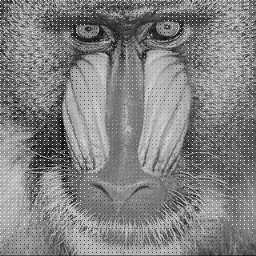

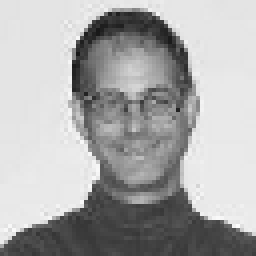

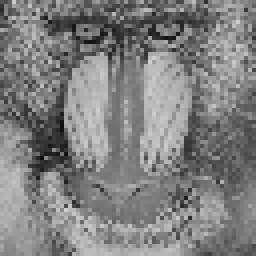

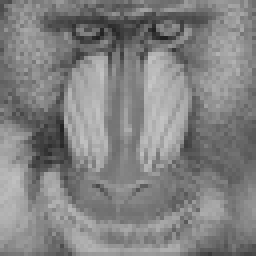

In [4]:
display(im)
display(im00)
display(im11)
display(im_avg)